<h1><center>Semantic Segmentation: Let's classify each pixel</center></h1>
 

Q.) What is segmentation ?

The aim of **segmentation** is to partition an image into a collection of set of pixels. 

What could be such a collection of pixels:

* Meaningful regions (coherent objects)

* Linear Structures (line, curve,...)

* Shapes (circles, ellipses,...)

<img src="img/seg.png">

But that's not all. What if we want to explore more and want know pixels which occupy which category amongst the defined ones.

**Semantic Segmentation:** Semantic Segmentation of an image is the task to assign each pixel in the input image a semantic class in order to get a pixel-wise dense classification. 
<img src="img/ss_tot.png">

Traditonal methods do feature representation and go up in a hierarchial way to do the segmentation.With the popularity of deep learning in recent years, many semantic segmentation problems are being tackled using deep architectures, most often Convolutional Neural Nets, which surpass other approaches by a large margin in terms of accuracy and efficiency. Breakthrough came in this field of semantic segmentation when **Fully Convolutional Networks** were first introduced in 2014 **Long et. al.** to perform end-to-end segmentation of natural images.
<img src="img/fcn.png">


<h1><center>Applications of Semantic Segmentation</center></h1>

Semantic segmentation is generally used for:

-  Autonomous driving (Scene understanding)
-  Medical image segmentation
-  Robot Vision and Understanding

The importance of scene understanding as a core computer vision problem is highlighted by the fact that an increasing number of applications nourish from inferring knowledge from imagery. Some of those applications include self-driving vehicles, human-computer interaction, virtual reality etc.

We are going to look at some of the dataset which is widely used for the task of scene understanding and hence apply our semantic segmnetation algorithm on the same.



## Cityscapes Dataset

**The Cityscapes Dataset** focuses on semantic understanding of urban street scenes. This dataset has been collected over 50 cities of Germany in different settings. It contains 2975 training and 500 validation images with publicly available annotations, as well as 1525 test images. The dataset contains fine and coarse annotations that have been manually annotated. 

The authors came up with 30 visual classes for annotation, which are grouped  into  eight  categories: flat, construction, nature, vehicle, sky, object, human, and void. (Please see the image below from their paper!!)

<img src="img/class.png">

Image | Color Mask
- | - 
![alt](img/aachen.png) | ![alt](img/aachen_color.png)
![alt](img/zurich.png) | ![alt](img/zurich_color.png)



## Indian Driving Dataset

**Indian Driving Dataset: Lite** or abbreviated IDD is a dataset targetted to acquire images in natural unconstrained setting available in India. It comprises 10,003 images from 182 driving sequences, divided in 6,993/981/2,029 images for training, validation and test, respectively. The dataset has multi label level hierarchy to report results respectively.
  * L4: 30 labels
  * L3: 26 labels
  * L2: 16 labels
  * L1: 7 labels
  
Group of labels can be groupped together to form one form of label.

<img src="img/label_idd.png">


<img src="img/idd_img.png">
<img src="img/idd_lab_2.png">

We will be training and testing our code on IDD Lite which is a subsampled version of the dataset. We believe that this
will enable quick prototyping useful in optimum parameter and architecture search, and encourage deployment on low
resource hardware.

### Metrics used in evaluation of Semantic Segmentation algorithm

The different metrics used for evaluating semantic segmenatation algorithm are given below in the picture: 
<center> Pixel Accuracy </center> | <center> Mean Accuracy </center>
- | -
![alt](img/pa_ss.png) | ![alt](img/ma_ss.png)

<center> Mean IOU </center> | <center> Frequency Weighted IOU </center>
- | -
![alt](img/miou_ss.png) | ![alt](img/fiou_ss.png)



<h1><center> Model Architectures for Semantic Segmentation</h1></center>

In a nutshell, there are two types of architectures that are prominent in semantic segmentation.

* Encoder Decoder Based Architecture

**Encoder**: A pre-trained classification network like VGG/ResNet followed by a decoder network. 

**Decoder**: The task of the decoder is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification. This is where most architectures differ. Some architectures directly upsample the feature map and some use complex architecture to get more refined outputs. 


* Spatial Pyramid Pooling Based Architecture

  **Extract features from CNN based architecture**

  **Sub region pooling** 

  **1X1 Convolution for feature concatenation/ dimension reduction**

  **Interpolation for upsampling**

Take a look at the architectures !!

<center> Spatial Pyramid Pooling Architecture</center> | <center> Encoder Decoder Architecture </center>
- | -
![alt](img/spp.png) | ![alt](img/enc.png)


<img src="img/spp_2.png">
<img src="img/encode_ss.jpeg">


In [1]:
#Importing the necessary libraries needed for processing

import random
import time
import numpy as np
import torch
print(torch.__version__)
import math

1.0.1.post2


In [2]:
#Importing library to do image related operations
from PIL import Image, ImageOps

In [3]:
#Importing the important functionalities of Pytorch such as the dataloader, Variable, transform's 
#and optimizer related functions.

from torch.optim import SGD, Adam, lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import  Resize
from torchvision.transforms import ToTensor, ToPILImage


In [4]:
# Importing the dataset class for VOC12 and cityscapes
from dataset import cityscapes
from dataset import idd_lite

import sys
print(sys.executable)

#Importing the Relabel, ToLabel and Colorize class from transform.py file
from transform import Relabel, ToLabel, Colorize
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline



/usr/bin/python3


In [5]:
import importlib
from iouEval import iouEval, getColorEntry #importing iouEval class from the iouEval.py file
from shutil import copyfile

### A few global parameters ###

In [12]:
NUM_CHANNELS = 3 #RGB Images
NUM_CLASSES = 8 #IDD Lite has 8 labels or Level1 hierarchy of labels
USE_CUDA = torch.cuda.is_available() 
IMAGE_HEIGHT = 160
DATA_ROOT = '/home/avideep/summer-school-iiith-2019/cv/SS19/6-segmentation/idd1_lite'
BATCH_SIZE = 2
NUM_WORKERS = 4
NUM_EPOCHS = 1
ENCODER_ONLY = True
device = torch.device("cuda" )
#device = 'cuda'
color_transform = Colorize(NUM_CLASSES)
image_transform = ToPILImage()


In [13]:
IOUTRAIN = False
IOUVAL = True

In [14]:
#Augmentations - different function implemented to perform random augments on both image and target
class MyCoTransform(object):
    def __init__(self, enc, augment=True, height=160):
        self.enc=enc
        self.augment = augment
        self.height = height
        pass
    def __call__(self, input, target):
        # Resizing data to required size
        input =  Resize((self.height,320), Image.BILINEAR)(input)
        target = Resize((self.height,320), Image.NEAREST)(target)

        if(self.augment):
            # Random horizontal flip
            hflip = random.random()
            if (hflip < 0.5):
                input = input.transpose(Image.FLIP_LEFT_RIGHT)
                target = target.transpose(Image.FLIP_LEFT_RIGHT)
            
            #Random translation 0-2 pixels (fill rest with padding)
            transX = random.randint(0, 2) 
            transY = random.randint(0, 2)

            input = ImageOps.expand(input, border=(transX,transY,0,0), fill=0)
            target = ImageOps.expand(target, border=(transX,transY,0,0), fill=7) #pad label filling with 7
            input = input.crop((0, 0, input.size[0]-transX, input.size[1]-transY))
            target = target.crop((0, 0, target.size[0]-transX, target.size[1]-transY))   

        input = ToTensor()(input)
        
        target = ToLabel()(target)
        
        target = Relabel(255,7)(target)
        return input, target


### Loading Data

We'll follow pytorch recommended semantics, and use a dataloader to load the data. 

In [15]:
best_acc = 0

co_transform = MyCoTransform(ENCODER_ONLY, augment=True, height=IMAGE_HEIGHT)
co_transform_val = MyCoTransform(ENCODER_ONLY, augment=False, height=IMAGE_HEIGHT)

#train data
dataset_train = idd_lite(DATA_ROOT, co_transform, 'train')
print(len(dataset_train))
#test data
dataset_val = idd_lite(DATA_ROOT, co_transform_val, 'val')
print(len(dataset_val))


# NOTE: PLEASE DON'T CHANGE batch_size and num_workers here. We have limited resources.
loader_train = DataLoader(dataset_train, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE, shuffle=True)
loader_val = DataLoader(dataset_val, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE, shuffle=False)


673
110


## Cross Entropy  Loss ##
Negative Log Loss   |Plot of -log(x) vs x
- | - 
![alt](img/nll.png) | ![alt](img/nll-log.png)

The negative log-likelihood becomes unhappy at smaller values, where it can reach infinite unhappiness (that’s too sad), and becomes less unhappy at larger values. Because we are summing the loss function to all the correct classes, what’s actually happening is that whenever the network assigns high confidence at the correct class, the unhappiness is low, but when the network assigns low confidence at the correct class, the unhappiness is high.

In [16]:
criterion = torch.nn.CrossEntropyLoss()

### Take a look at the data? ###

337


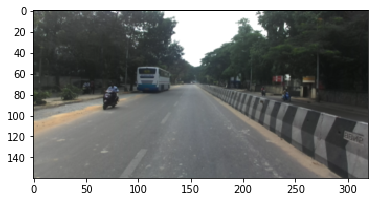

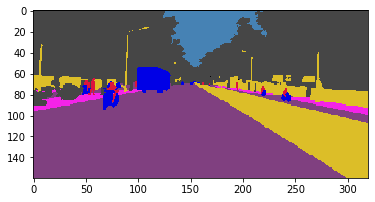

In [17]:
#get some random training images
print(len(loader_train))
#print(len(loader_val))
dataiter = iter(loader_train)
#print(dataiter.next())
(images, labels) = dataiter.next()
#for step, (images, labels) in enumerate(loader_train):
plt.figure()
plt.imshow(ToPILImage()(images[0].cpu()))
plt.figure()
plt.imshow(ToPILImage()(Colorize()(labels[0].cpu())))  
#break

## Model ##

In this lab, we would be using [ERFNET](http://www.robesafe.uah.es/personal/eduardo.romera/pdfs/Romera17iv.pdf)
model, which is an encoder-decoder architecture. Please see the image below !!
<img src="img/erfnet.png">
<img src="img/erfnet-model.png">


We show two ways to train the **ERFNET architecture** on a standard dataset:

-  Training the encoder and decoder from the scratch.
-  Just training the encoder and then bilinearly upsampling the encoder's output to match input image size .

ERFNET reformulates the **Resnet architecture** into novel 1-d bottleneck and non bottleneck 1-d blocks (See more in the paper). Because of the ResNet architecture, the information of semantic boundary is passed through the residual mappings and hence the need for explicit skip connections is not required.   

Downsampling (reducing the spatial resolution) has the drawback of reducing the accuracy (coarser outputs), but it
also  has  two  benefits:  it  lets  the  deeper  layers  gather  more context  (to  improve  classification)  and  it  helps  to  reduce computation.

Power vs FPS | Category MIOU vs FPS
- | - 
![alt](img/comp_ss.png) | ![alt](img/comp_ss_2.png)

In [18]:
model_file = importlib.import_module('erfnet')
model = model_file.Net(NUM_CLASSES).to(device)
    

### Optimizer ###

In [19]:
# We use adam optimizer. It can be replaced with SGD and other optimizers
optimizer = Adam(model.parameters(), 5e-4, (0.9, 0.999),  eps=1e-08, weight_decay=1e-4) 
start_epoch = 1

In [20]:
print(device)

cuda


### Training Procedure ###

In [ ]:
import os
steps_loss = 50
my_start_time = time.time()
for epoch in range(start_epoch, NUM_EPOCHS+1):
    print("----- TRAINING - EPOCH", epoch, "-----")

    epoch_loss = []
    time_train = []

    doIouTrain = IOUTRAIN   
    doIouVal =  IOUVAL      

    if (doIouTrain):
        iouEvalTrain = iouEval(NUM_CLASSES)

    model.train()
    for step, (images, labels) in enumerate(loader_train):

        start_time = time.time()
        inputs = images.to(device)
        targets = labels.to(device)
    
        outputs = model(inputs, only_encode=ENCODER_ONLY)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        loss = criterion(outputs, targets[:, 0])
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        time_train.append(time.time() - start_time)

        if (doIouTrain):
            #start_time_iou = time.time()
            iouEvalTrain.addBatch(outputs.max(1)[1].unsqueeze(1).data, targets.data)
            #print ("Time to add confusion matrix: ", time.time() - start_time_iou)      

        # print statistics
        if steps_loss > 0 and step % steps_loss == 0:
            average = sum(epoch_loss) / len(epoch_loss)
            print('loss: {average:0.4} (epoch: {epoch}, step: {step})', "// Avg time/img: %.4f s" % (sum(time_train) / len(time_train) / BATCH_SIZE))


    average_epoch_loss_train = sum(epoch_loss) / len(epoch_loss)

    iouTrain = 0
    if (doIouTrain):
        iouTrain, iou_classes = iouEvalTrain.getIoU()
        iouStr = getColorEntry(iouTrain)+'{:0.2f}'.format(iouTrain*100) + '\033[0m'
        print ("EPOCH IoU on TRAIN set: ", iouStr, "%")  
my_end_time = time.time()
print(my_end_time - my_start_time)


----- TRAINING - EPOCH 1 -----


/home/avideep/.local/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.3658 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.2307 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.2299 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.2298 s


### Validation ###

In [ ]:
#Validate on val images after each epoch of training
print("----- VALIDATING - EPOCH", epoch, "-----")
model.eval()
epoch_loss_val = []
time_val = []

if (doIouVal):
    iouEvalVal = iouEval(NUM_CLASSES)

for step, (images, labels) in enumerate(loader_val):
    start_time = time.time()

    inputs = images.to(device)    
    targets = labels.to(device)
    
    with torch.no_grad():
        outputs = model(inputs, only_encode=ENCODER_ONLY) 
        #outputs = model(inputs)
    loss = criterion(outputs, targets[:, 0])
    epoch_loss_val.append(loss.item())
    time_val.append(time.time() - start_time)


    #Add batch to calculate TP, FP and FN for iou estimation
    if (doIouVal):
        #start_time_iou = time.time()
        iouEvalVal.addBatch(outputs.max(1)[1].unsqueeze(1).data, targets.data)
        #print ("Time to add confusion matrix: ", time.time() - start_time_iou)
        
    if steps_loss > 0 and step % steps_loss == 0:
        average = sum(epoch_loss_val) / len(epoch_loss_val)
        print('VAL loss: {average:0.4} (epoch: {epoch}, step: {step})', 
                "// Avg time/img: %.4f s" % (sum(time_val) / len(time_val) / BATCH_SIZE))


average_epoch_loss_val = sum(epoch_loss_val) / len(epoch_loss_val)

iouVal = 0
if (doIouVal):

    iouVal, iou_classes = iouEvalVal.getIoU()
    print(iou_classes)
    iouStr = getColorEntry(iouVal)+'{:0.2f}'.format(iouVal*100) + '\033[0m'
    print ("EPOCH IoU on VAL set: ", iouStr, "%") 



 ### Visualizing the Output###

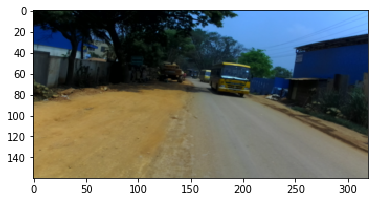

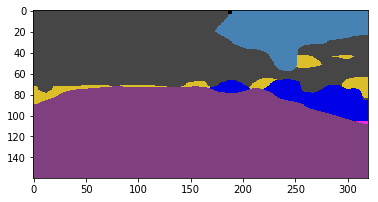

In [17]:
# Qualitative Analysis
dataiter = iter(loader_val)
images, labels = dataiter.next()

if USE_CUDA:
    images = images.to(device)

inputs = images.to(device)

with torch.no_grad():
    outputs = model(inputs, only_encode=ENCODER_ONLY)

label = outputs[0].max(0)[1].byte().cpu().data

label_color = Colorize()(label.unsqueeze(0))

label_save = ToPILImage()(label_color)
plt.figure()
plt.imshow(ToPILImage()(images[0].cpu()))
plt.figure()
plt.imshow(label_save)
